In [1]:
import json

import pandas as pd
import numpy as np

from datetime import datetime, timedelta

import matplotlib.pyplot as plt  # to make plots
import matplotlib.dates as mdates  # to use ConciseDateFormatter

In [2]:
pilot_data_root = "C:/Users/nikhi/Box/AI-READI/working dataset/dataset/"  # change this to your own path

# manifest.tsv
manifest_path = pilot_data_root + "/wearable_blood_glucose/manifest.tsv"
print(manifest_path)

C:/Users/nikhi/Box/AI-READI/working dataset/dataset//wearable_blood_glucose/manifest.tsv


In [3]:
dfm = pd.read_csv(manifest_path, sep='\t')
print(dfm.columns)

Index(['participant_id', 'glucose_filepath', 'glucose_level_record_count',
       'average_glucose_level_mg_dl', 'glucose_sensor_sampling_duration_days',
       'glucose_sensor_id', 'manufacturer', 'manufacturer_model_name'],
      dtype='object')


## Analysis

In [4]:
print(f"Total no. of participants contirbuted to blood glucose are: {dfm['participant_id'].nunique()}  ")
dfm.head()

Total no. of participants contirbuted to blood glucose are: 1049  


,participant_id,glucose_filepath,glucose_level_record_count,average_glucose_level_mg_dl,glucose_sensor_sampling_duration_days,glucose_sensor_id,manufacturer,manufacturer_model_name
0,1001,wearable_blood_glucose/continuous_glucose_moni...,2856,123.304272,11,PG15103578,Dexcom,G6
1,1002,wearable_blood_glucose/continuous_glucose_moni...,2844,116.446203,11,PG15103578,Dexcom,G6
2,1003,wearable_blood_glucose/continuous_glucose_moni...,2856,208.075280,11,PG15103578,Dexcom,G6
3,1004,wearable_blood_glucose/continuous_glucose_moni...,2856,188.661064,11,PG15103578,Dexcom,G6
4,1005,wearable_blood_glucose/continuous_glucose_moni...,2856,262.778361,11,PG15103578,Dexcom,G6


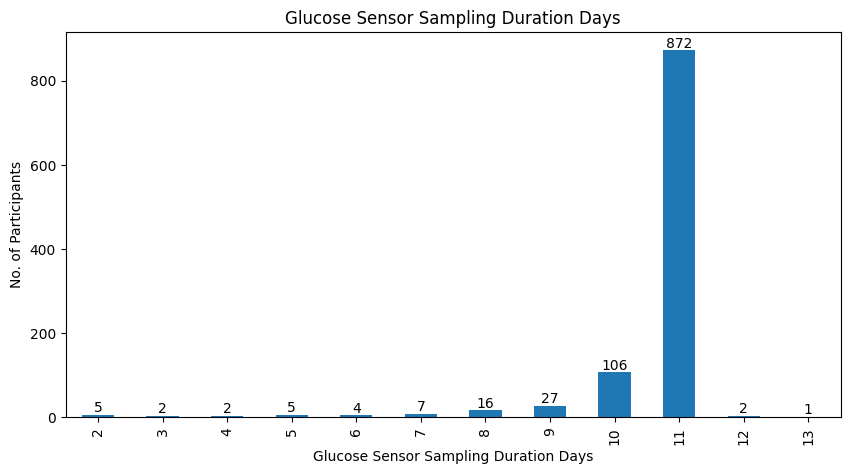

In [7]:
[dfm['glucose_sensor_sampling_duration_days'].unique()]
# plot the graph to know where the data is most in glucose_sensor_sampling_duration_days

value_counts = dfm['glucose_sensor_sampling_duration_days'].value_counts().sort_index()
value_counts.plot(kind='bar', figsize=(10, 5))
plt.title('Glucose Sensor Sampling Duration Days')
plt.xlabel('Glucose Sensor Sampling Duration Days')
plt.ylabel('No. of Participants')

# Annotate each bar with the exact number
for index, value in enumerate(value_counts):
    plt.text(index, value, str(value), ha='center', va='bottom')

plt.show()



2069
2309
2328


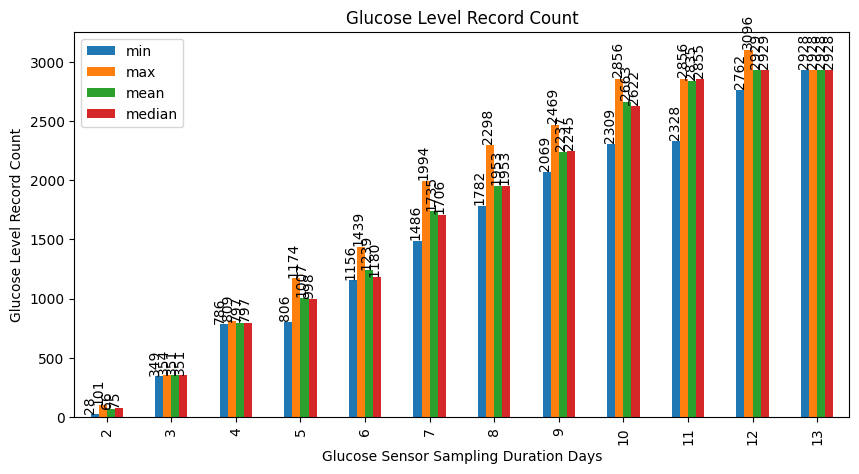

The glucose level record count that covers more than 80% of the participants is: 2856
The glucose level record count that covers more than 90% of the participants is: 2856


In [8]:
# get me the minimum of blood_glucose_count has for 9 - gglucose_sensor_sampling_duration_days
print(dfm[dfm['glucose_sensor_sampling_duration_days'] == 9]['glucose_level_record_count'].min())
print(dfm[dfm['glucose_sensor_sampling_duration_days'] == 10]['glucose_level_record_count'].min())
print(dfm[dfm['glucose_sensor_sampling_duration_days'] == 11]['glucose_level_record_count'].min())

# instead of above can i do a single plot where all this information is present min, max, mean, median of glucose_level_record_count
ax = dfm.groupby('glucose_sensor_sampling_duration_days')['glucose_level_record_count'].agg(['min', 'max', 'mean', 'median']).plot(kind='bar', figsize=(10, 5))
plt.title('Glucose Level Record Count')
plt.xlabel('Glucose Sensor Sampling Duration Days')
plt.ylabel('Glucose Level Record Count')

# Annotate each bar with the exact number vertically
for p in ax.patches:
    ax.annotate(str(int(p.get_height())), (p.get_x() * 1.005, p.get_height() * 1.005), rotation=90, ha='center', va='bottom')

plt.show()


# Find the glucose level record count that covers more than 80-90% of the participants
total_participants = dfm['participant_id'].nunique()
threshold_80_percent = total_participants * 0.80
threshold_90_percent = total_participants * 0.90

# Calculate cumulative sum of participants for each glucose level record count
cumulative_sum = dfm['glucose_level_record_count'].value_counts().sort_index().cumsum()

# Find the glucose level record count that covers more than 80% of the participants
glucose_count_80_percent = cumulative_sum[cumulative_sum >= threshold_80_percent].index[0]
print(f"The glucose level record count that covers more than 80% of the participants is: {glucose_count_80_percent}")

# Find the glucose level record count that covers more than 90% of the participants
glucose_count_90_percent = cumulative_sum[cumulative_sum >= threshold_90_percent].index[0]
print(f"The glucose level record count that covers more than 90% of the participants is: {glucose_count_90_percent}")

In [10]:
# glucose_sensor_sampling_duration_days greater than or equal to 10 count
print(dfm[dfm['glucose_sensor_sampling_duration_days'] > 9]['participant_id'].nunique())

# glucose_leep_record_count greater than or equal to 2069 count
print(dfm[dfm['glucose_level_record_count'] > 2069]['participant_id'].nunique())

981
1008


## Extract the data from single patient

In [5]:
particpants_metadata_path = pilot_data_root + 'participants.tsv'
df_participants = pd.read_csv(particpants_metadata_path, sep='\t')
print(df_participants.columns)

Index(['participant_id', 'clinical_site', 'study_group', 'age',
       'study_visit_date', 'recommended_split', 'cardiac_ecg', 'clinical_data',
       'environment', 'retinal_flio', 'retinal_oct', 'retinal_octa',
       'retinal_photography', 'wearable_activity_monitor',
       'wearable_blood_glucose'],
      dtype='object')


## Extracting features

In [12]:
def flatten_json(y):
    out = {}
    def flatten(x, name=''):
        if type(x) is dict:
            for a in x:
                flatten(x[a], name + a + '_')
        elif type(x) is list:
            i = 0
            for a in x:
                flatten(a, name + str(i) + '_')
                i += 1
        else:
            out[name[:-1]] = x
    flatten(y)
    return out

def get_flatten_dict_from_path(pid):
    pid_cgm = dfm[dfm['participant_id'] == pid]['glucose_filepath'].values[0]
    cgm_path = pilot_data_root + pid_cgm
    print(f"Attempting to open file: {cgm_path}")  # Debugging line

    # read the mHealth formatted data as json
    with open(cgm_path, 'r') as f:
        data = json.load(f)

    # CGM observations are in a list of nested dicts; flatten these 
    list_of_body_dicts = [flatten_json(observation) for observation in data['body']['cgm']]
    return list_of_body_dicts

In [34]:
# Extract the first participant IDs from the manifest
# first_two_pids = dfm['participant_id'][:]

low_high_counts = []

for pid in first_two_pids:
    with open(pilot_data_root + dfm[dfm['participant_id'] == pid]['glucose_filepath'].values[0], 'r') as f:
        data = json.load(f)
    low_count = sum(1 for record in data['body']['cgm'] if 'blood_glucose' in record and record['blood_glucose']['value'] == 'Low')
    high_count = sum(1 for record in data['body']['cgm'] if 'blood_glucose' in record and record['blood_glucose']['value'] == 'High')
    
    # Extract start and end date times and transmitter time values
    start_date_time = data['body']['cgm'][0]['effective_time_frame']['time_interval']['start_date_time']
    end_date_time = data['body']['cgm'][-1]['effective_time_frame']['time_interval']['end_date_time']
    
    # Count the length of the dictionary inside cgm
    glucose_level_record_count = len(data['body']['cgm'])
    
    low_high_counts.append({
        'participant_id': pid, 
        'Low': low_count, 
        'High': high_count, 
        'start_date_time': start_date_time, 
        'end_date_time': end_date_time,
        'glucose_level_record_count': glucose_level_record_count
    })

# Convert the list of dictionaries to a DataFrame
df_low_high_counts = pd.DataFrame(low_high_counts)

# Save the DataFrame to a CSV file
csv_path_low_high_counts = pilot_data_root + "/cleaned_data/low_high_counts.csv"
df_low_high_counts.to_csv(csv_path_low_high_counts, index=False)
print(f"CSV file saved to {csv_path_low_high_counts}")


CSV file saved to C:/Users/nikhi/Box/AI-READI/990cf641-e7db-46d6-9359-aa59fa6825a5/dataset//cleaned_data/low_high_counts.csv


In [8]:
csv_path_low_high_counts = pilot_data_root + "/cleaned_data/low_high_counts.csv"
# import this json file to see the data
df_low_high_counts = pd.read_csv(csv_path_low_high_counts)
print(df_low_high_counts.head())

   participant_id  Low  High       start_date_time         end_date_time  \
0            1001    0     0  2023-07-27T23:51:23Z  2023-08-06T21:46:23Z   
1            1002  545     0  2023-08-01T20:40:26Z  2023-08-11T18:35:26Z   
2            1003    0     9  2023-08-02T21:16:37Z  2023-08-12T19:11:37Z   
3            1004    0     0  2023-08-08T17:34:15Z  2023-08-18T15:29:15Z   
4            1005    0   121  2023-08-08T21:15:41Z  2023-08-18T19:10:41Z   

   glucose_level_record_count  
0                        2856  
1                        2844  
2                        2856  
3                        2856  
4                        2856  


No. of participants with no 'Low' and 'High' values: 809
Minimum glucose level record count: 349
Maximum glucose level record count: 2928


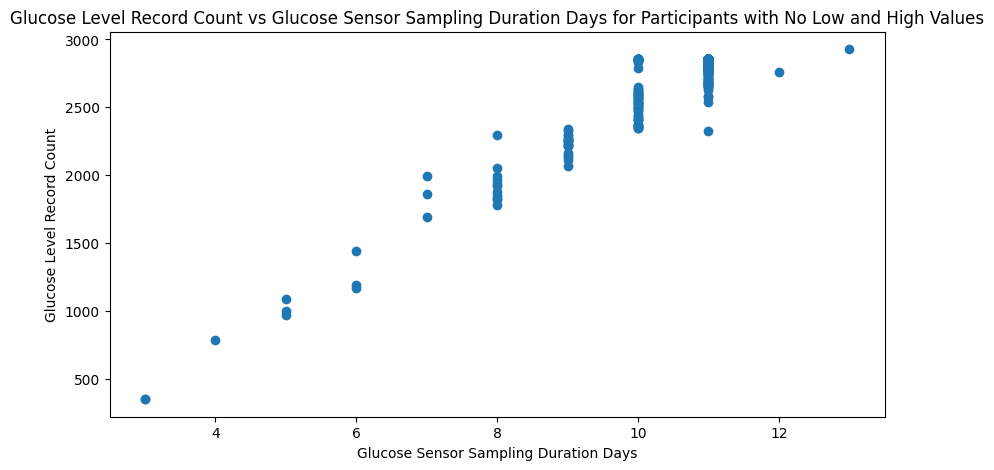

No. of participants with glucose_level_record_count > 2069: 786


In [9]:
# Filter the DataFrame for participants who have both 'Low' and 'High' values as 0
df_no_error = df_low_high_counts[(df_low_high_counts['Low'] == 0) & (df_low_high_counts['High'] == 0)]

# Merge df_no_error with dfm to get the 'glucose_sensor_sampling_duration_days' column
df_no_error = df_no_error.merge(dfm[['participant_id', 'glucose_sensor_sampling_duration_days']], on='participant_id', how='left')

# Print the count of participants who have both 'Low' and 'High' values as 0
print(f"No. of participants with no 'Low' and 'High' values: {df_no_error.shape[0]}")
print(f"Minimum glucose level record count: {df_no_error['glucose_level_record_count'].min()}")
print(f"Maximum glucose level record count: {df_no_error['glucose_level_record_count'].max()}")

# Plot the graph of glucose_level_record_count vs glucose_sensor_sampling_duration_days for df_no_error
plt.figure(figsize=(10, 5))
plt.scatter(df_no_error['glucose_sensor_sampling_duration_days'], df_no_error['glucose_level_record_count'])
plt.title('Glucose Level Record Count vs Glucose Sensor Sampling Duration Days for Participants with No Low and High Values')
plt.xlabel('Glucose Sensor Sampling Duration Days')
plt.ylabel('Glucose Level Record Count')
plt.show()

# Print the count of participants with glucose_level_record_count greater than 2069
print(f"No. of participants with glucose_level_record_count > 2069: {df_no_error[df_no_error['glucose_level_record_count'] > 2069].shape[0]}")

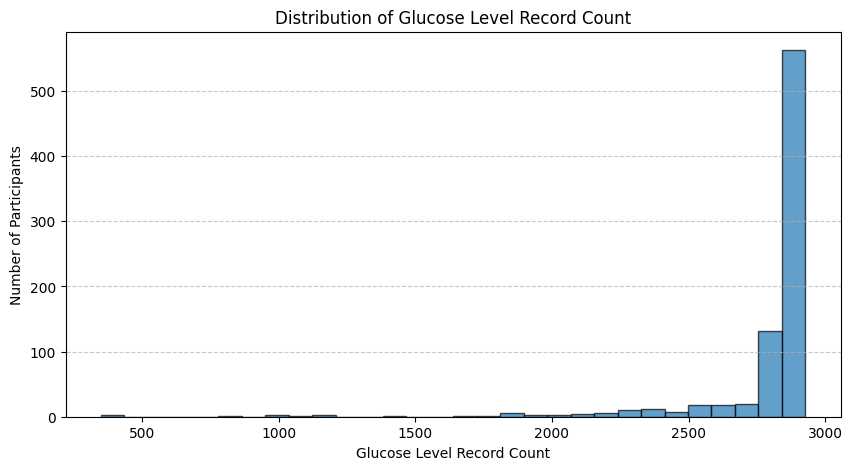

1st percentile: 1459.4 (more than 99% of participants have more than this)
No. of participants with glucose_level_record_count > 1459.4: 800
2nd percentile: 1921.88 (more than 98% of participants have more than this)
No. of participants with glucose_level_record_count > 1921.88: 792
3rd percentile: 2137.56 (more than 97% of participants have more than this)
No. of participants with glucose_level_record_count > 2137.56: 784
5th percentile: 2326.2 (more than 95% of participants have more than this)
No. of participants with glucose_level_record_count > 2326.2: 768
7th percentile: 2471.4 (more than 93% of participants have more than this)
No. of participants with glucose_level_record_count > 2471.4: 752
10th percentile: 2597.8 (more than 90% of participants have more than this)
No. of participants with glucose_level_record_count > 2597.8: 728
25th percentile: 2830.0 (more than 75% of participants have more than this)
No. of participants with glucose_level_record_count > 2830.0: 605
50th (m

In [10]:
import matplotlib.pyplot as plt
import numpy as np

# Extract the glucose level record counts
record_counts = df_no_error["glucose_level_record_count"]

# Plot histogram
plt.figure(figsize=(10, 5))
plt.hist(record_counts, bins=30, edgecolor="black", alpha=0.7)
plt.xlabel("Glucose Level Record Count")
plt.ylabel("Number of Participants")
plt.title("Distribution of Glucose Level Record Count")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()

# Calculate lower percentiles
percentiles = np.percentile(record_counts, [1, 2, 3, 5, 7, 10, 25, 50])
percentile_labels = ["1st", "2nd", "3rd", "5th", "7th", "10th", "25th", "50th (median)"]

for label, value in zip(percentile_labels, percentiles):
    if label == "50th (median)":
        percentage = 50
    else:
        percentage = int(label[:-2])
    print(f"{label} percentile: {value} (more than {100 - percentage}% of participants have more than this)")
    print(f"No. of participants with glucose_level_record_count > {value}: {df_no_error[df_no_error['glucose_level_record_count'] > value].shape[0]}")


In [11]:
# Filter participants with glucose_level_record_count >= 2138 and no 'Low' and 'High' values
filtered_participants = df_no_error[(df_no_error['glucose_level_record_count'] >= 2138) & (df_no_error['Low'] == 0) & (df_no_error['High'] == 0)]['participant_id'].tolist()

print(f"Participants with glucose_level_record_count >= 2138 and no 'Low' and 'High' values: {filtered_participants}")

Participants with glucose_level_record_count >= 2138 and no 'Low' and 'High' values: [1001, 1004, 1006, 1008, 1010, 1011, 1012, 1013, 1015, 1016, 1017, 1018, 1019, 1021, 1023, 1024, 1025, 1026, 1028, 1029, 1030, 1031, 1033, 1034, 1036, 1037, 1040, 1043, 1044, 1046, 1048, 1049, 1050, 1051, 1052, 1053, 1054, 1055, 1056, 1057, 1059, 1060, 1065, 1066, 1067, 1069, 1070, 1071, 1072, 1074, 1076, 1077, 1078, 1079, 1080, 1081, 1082, 1084, 1086, 1087, 1088, 1089, 1090, 1091, 1092, 1093, 1096, 1097, 1098, 1100, 1101, 1103, 1104, 1105, 1106, 1107, 1108, 1109, 1110, 1112, 1114, 1115, 1116, 1117, 1118, 1119, 1120, 1121, 1122, 1123, 1124, 1126, 1127, 1129, 1130, 1131, 1132, 1133, 1135, 1136, 1137, 1138, 1141, 1142, 1143, 1144, 1145, 1146, 1148, 1149, 1150, 1151, 1153, 1155, 1157, 1158, 1159, 1160, 1161, 1162, 1163, 1164, 1166, 1167, 1168, 1169, 1170, 1171, 1173, 1174, 1175, 1177, 1178, 1179, 1180, 1182, 1183, 1184, 1186, 1188, 1189, 1190, 1191, 1193, 1195, 1196, 1199, 1200, 1201, 1202, 1203, 1204, 12

In [12]:
index_of_participant = filtered_participants.index(7288)
print(f"Index of participant_id 7288: {index_of_participant}")

Index of participant_id 7288: 699


In [ ]:
# Extract the participant IDs from the manifest
first_few_pids = df_no_error[(df_no_error['glucose_level_record_count'] >= 2138) & (df_no_error['Low'] == 0) & (df_no_error['High'] == 0)]['participant_id'].tolist()

batch_size = 100
all_data_records = []

for batch_start in range(0, len(first_few_pids), batch_size):
    batch_end = min(batch_start + batch_size, len(first_few_pids))
    batch_pids = first_few_pids[batch_start:batch_end]
    
    batch_data_records = []
    
    for pid in batch_pids:
        list_of_body_dicts = get_flatten_dict_from_path(pid)
        if len(list_of_body_dicts) < 2138:
            print(f"Participant {pid} has less than 2138 records. Ignoring this participant.")
            continue

        blood_glucose_values = [record['blood_glucose_value'] for record in list_of_body_dicts]

        data_records = [
            {
                'participant_id': pid,
                'time_index': i + 1,
                'timestamp': record['effective_time_frame_time_interval_start_date_time'],
                'transmitter_time_value': record['transmitter_time_value'],
                'age': df_participants.loc[df_participants['participant_id'] == pid, 'age'].iloc[0],
                'blood_glucose_value': blood_glucose_values[i],
                'glucose_change_rate': blood_glucose_values[i] - blood_glucose_values[i - 1] if i > 0 else 0,
                'study_group': df_participants.loc[df_participants['participant_id'] == pid, 'study_group'].iloc[0]
            }
            for i, record in enumerate(list_of_body_dicts[:2138 ])  # Limit to 2138 records
        ]

        batch_data_records.extend(data_records)
    
    # Save each batch to a CSV file
    batch_df = pd.DataFrame(batch_data_records)
    batch_csv_path = pilot_data_root + f"/cleaned_data/batch_{batch_start}_{batch_end}.csv"
    batch_df.to_csv(batch_csv_path, index=False)
    print(f"Batch CSV file saved to {batch_csv_path}")
    
    all_data_records.extend(batch_data_records)

# Create a DataFrame for all participants
df_all_participants = pd.DataFrame(all_data_records)

# Convert the timestamp to the desired format
df_all_participants['timestamp'] = pd.to_datetime(df_all_participants['timestamp']).dt.strftime('%Y-%m-%d %H:%M:%S')

# Export the DataFrame to a single CSV file
csv_path = pilot_data_root + "/cleaned_data/all_participants_blood_glucose_values.csv"
df_all_participants.to_csv(csv_path, index=False)
print(f"CSV file saved to {csv_path}")

Attempting to open file: C:/Users/nikhi/Box/AI-READI/990cf641-e7db-46d6-9359-aa59fa6825a5/dataset/wearable_blood_glucose/continuous_glucose_monitoring/dexcom_g6/1001/1001_DEX.json
Attempting to open file: C:/Users/nikhi/Box/AI-READI/990cf641-e7db-46d6-9359-aa59fa6825a5/dataset/wearable_blood_glucose/continuous_glucose_monitoring/dexcom_g6/1004/1004_DEX.json
Attempting to open file: C:/Users/nikhi/Box/AI-READI/990cf641-e7db-46d6-9359-aa59fa6825a5/dataset/wearable_blood_glucose/continuous_glucose_monitoring/dexcom_g6/1006/1006_DEX.json
Attempting to open file: C:/Users/nikhi/Box/AI-READI/990cf641-e7db-46d6-9359-aa59fa6825a5/dataset/wearable_blood_glucose/continuous_glucose_monitoring/dexcom_g6/1008/1008_DEX.json
Attempting to open file: C:/Users/nikhi/Box/AI-READI/990cf641-e7db-46d6-9359-aa59fa6825a5/dataset/wearable_blood_glucose/continuous_glucose_monitoring/dexcom_g6/1010/1010_DEX.json
Attempting to open file: C:/Users/nikhi/Box/AI-READI/990cf641-e7db-46d6-9359-aa59fa6825a5/dataset/we

## Training the Model

In [6]:
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# Export the DataFrame to a single CSV file
csv_path = pilot_data_root + "all_participants_blood_glucose_values.csv"
df_all_participants = pd.read_csv(csv_path)

# Prepare the data for LSTM model
df_all_participants['blood_glucose_value'] = pd.to_numeric(df_all_participants['blood_glucose_value'], errors='coerce')
df_all_participants = df_all_participants.dropna(subset=['blood_glucose_value'])

# Normalize the blood glucose values
scaler = MinMaxScaler(feature_range=(0, 1))
df_all_participants['blood_glucose_value'] = scaler.fit_transform(df_all_participants['blood_glucose_value'].values.reshape(-1, 1))

# Create sequences for LSTM
def create_sequences(data, seq_length):
    sequences = []
    for i in range(len(data) - seq_length):
        sequences.append(data[i:i + seq_length])
    return np.array(sequences)

seq_length = 10
sequences = create_sequences(df_all_participants['blood_glucose_value'].values, seq_length)

X = sequences[:, :-1]
y = sequences[:, -1]

# Reshape X to be [samples, time steps, features]
X = X.reshape((X.shape[0], X.shape[1], 1))

# Build the LSTM model
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(seq_length - 1, 1)))
model.add(LSTM(50))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(X, y, epochs=20, batch_size=32)

# Save the model
model.save(pilot_data_root + "lstm_blood_glucose_model.h5")
print(f"LSTM model saved to {pilot_data_root + 'lstm_blood_glucose_model.h5'}")

Epoch 1/20


c:\Users\nikhi\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1692/1692 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 0.0033
Epoch 2/20
1692/1692 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 2.2650e-04
Epoch 3/20
1692/1692 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 1.8927e-04
Epoch 4/20
1692/1692 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 1.8017e-04
Epoch 5/20
1692/1692 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 1.8481e-04
Epoch 6/20
1692/1692 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 1.7755e-04
Epoch 7/20
1692/1692 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 1.7143e-04
Epoch 8/20
1692/1692 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 1.7040e-04
Epoch 9/20
1692/1692 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 1.7068e-04
Epoch 10/20
1692/1692 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 1.7026e-04
Epoch 11/20
1692/1692 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 1.7481e-04
Epoch 12/20
1692/1692 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 1.6734e-04
Epoch 13/20
1692/1692 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 1.7104e-04
Epoch 14/20
1692/1692 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss:

LSTM model saved to C:/Users/nikhi/Box/AI-READI/990cf641-e7db-46d6-9359-aa59fa6825a5/dataset/lstm_blood_glucose_model.h5


In [7]:
import joblib
joblib.dump(scaler, "scaler.pkl")  # Save the trained scaler

['scaler.pkl']

In [11]:
%pip install tensorflow

from tensorflow.keras.models import load_model

# Load the model

model_path = pilot_data_root + "lstm_blood_glucose_model.h5"
model = load_model(model_path)

# Prepare the test data
test_data = df_all_participants['blood_glucose_value'].values[-seq_length:]

# Normalize the test data
# Create sequences for testing
test_sequences = create_sequences(test_data, seq_length)

# Ensure test_sequences is not empty and has the correct shape
if len(test_sequences) == 0:
	raise ValueError("Test sequences are empty. Check the test data and sequence length.")

X_test = test_sequences[:, :-1]
y_test = test_sequences[:, -1]
# Create sequences for testing
test_sequences = create_sequences(test_data, seq_length)

X_test = test_sequences[:, :-1]
y_test = test_sequences[:, -1]

# Reshape X_test to be [samples, time steps, features]
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

# Make predictions
predictions = model.predict(X_test)

# Inverse transform the predictions to get the original scale
predictions = scaler.inverse_transform(predictions)

# Print the predictions
print("Predicted blood glucose values:")
print(predictions)

Note: you may need to restart the kernel to use updated packages.


ValueError: Test sequences are empty. Check the test data and sequence length.

In [32]:
!pip install torch

     ------------------------------------- 204.2/204.2 MB 14.2 MB/s eta 0:00:00
     ---------------------------------------- 134.6/134.6 kB ? eta 0:00:00
     ---------------------------------------- 1.7/1.7 MB 27.6 MB/s eta 0:00:00
     ---------------------------------------- 6.2/6.2 MB 35.9 MB/s eta 0:00:00
     ------------------------------------- 536.2/536.2 kB 35.1 MB/s eta 0:00:00



[notice] A new release of pip available: 22.2.1 -> 25.0
[notice] To update, run: python.exe -m pip install --upgrade pip


## Training using Pytorch

In [27]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.model_selection import train_test_split

# Load data
df = pd.read_csv("C:/Users/nikhi/Box/AI-READI/990cf641-e7db-46d6-9359-aa59fa6825a5/dataset/cleaned_data/batch_0_100.csv.")  

# Convert timestamp to datetime & extract time features
df['timestamp'] = pd.to_datetime(df['timestamp'])
df['hour'] = df['timestamp'].dt.hour  # Extract hour of the day
df = df.drop(columns=['timestamp'])  # Drop raw timestamp

# Normalize numerical features
scaler = MinMaxScaler()
df[['blood_glucose_value', 'glucose_change_rate', 'hour', 'age']] = scaler.fit_transform(
    df[['blood_glucose_value', 'glucose_change_rate', 'hour', 'age']]
)

print(df['study_group'].unique())
# Encode target labels (study_group)
label_encoder = LabelEncoder()
df['study_group'] = label_encoder.fit_transform(df['study_group'])  # Convert categories to numbers
# print(df)
print(df['study_group'].unique())

# Group by participant & create sequences
sequence_length = 2138  # Each participant has 2069 sequences
feature_cols = ['blood_glucose_value', 'glucose_change_rate', 'hour', 'age']

sequences = []
labels = []

for participant_id, group in df.groupby("participant_id"):
    values = group[feature_cols].values
    target = group['study_group'].iloc[0]  # Assign label for the participant
    
    # Create sequences
    for i in range(len(values) - sequence_length + 1):
        sequences.append(values[i : i + sequence_length])
        labels.append(target)

X = np.array(sequences)  # Shape: (num_samples, sequence_length, num_features)
y = np.array(labels)  # Shape: (num_samples,)

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

# Create DataLoader
train_data = torch.utils.data.TensorDataset(X_train_tensor, y_train_tensor)
test_data = torch.utils.data.TensorDataset(X_test_tensor, y_test_tensor)

train_loader = torch.utils.data.DataLoader(train_data, batch_size=32, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=32, shuffle=False)


['pre_diabetes_lifestyle_controlled'
 'oral_medication_and_or_non_insulin_injectable_medication_controlled'
 'healthy' 'insulin_dependent']
[3 2 0 1]


In [32]:
y_train

array([3, 2, 1, 3, 2, 0, 3, 2, 1, 1, 0, 0, 2, 3, 2, 0, 0, 0, 3, 3, 0, 0,
       2, 2, 0, 0, 0, 3, 0, 0, 3, 0, 2, 3, 3, 3, 2, 2, 0, 3, 2, 0, 0, 2,
       2, 3, 2, 0, 0, 2, 2, 3, 1, 0, 0, 2, 2, 3, 1, 0, 3, 3, 0, 0, 2, 0,
       1, 3, 1, 3, 0, 3, 0, 0, 0, 3, 3, 2, 0, 0])

In [24]:
# Convert the TensorDataset to a DataFrame to inspect the first few rows
# Reshape the tensor to 2D
train_data_reshaped = test_data.tensors[0].numpy().reshape(-1, len(feature_cols))
train_df = pd.DataFrame(train_data_reshaped, columns=feature_cols)
train_df['study_group'] = np.repeat(test_data.tensors[1].numpy(), test_data.tensors[0].shape[1])
train_df.head()

,blood_glucose_value,glucose_change_rate,hour,age,study_group
0,0.309192,0.586207,0.826087,0.35,2
1,0.306407,0.579310,0.826087,0.35,2
2,0.298050,0.565517,0.826087,0.35,2
3,0.289694,0.565517,0.826087,0.35,2
4,0.284123,0.572414,0.826087,0.35,2


In [2]:
import joblib
joblib.dump(scaler, "model/scaler.pkl")  # Save the trained scaler

['model/scaler.pkl']

In [3]:
# Define the LSTM model
class GlucoseLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(GlucoseLSTM, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)
    
    def forward(self, x):
        _, (h_n, _) = self.lstm(x)  # Get the last hidden state
        return self.fc(h_n[-1])  # Final classification layer

# Model Parameters
input_size = len(feature_cols)  # Number of input features
hidden_size = 64  # Number of LSTM units
num_layers = 2  # Number of stacked LSTM layers, Default is 1
num_classes = len(label_encoder.classes_)  # Number of study groups

model = GlucoseLSTM(input_size, hidden_size, num_layers, num_classes)


In [4]:
# Define loss function & optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 50

for epoch in range(num_epochs):
    model.train()
    total_loss = 0

    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {total_loss / len(train_loader):.4f}")


Epoch [1/50], Loss: 1.3728
Epoch [2/50], Loss: 1.3728
Epoch [3/50], Loss: 1.3452
Epoch [4/50], Loss: 1.3407
Epoch [5/50], Loss: 1.3360
Epoch [6/50], Loss: 1.3034
Epoch [7/50], Loss: 1.3189
Epoch [8/50], Loss: 1.2954
Epoch [9/50], Loss: 1.2939
Epoch [10/50], Loss: 1.3066
Epoch [11/50], Loss: 1.2847
Epoch [12/50], Loss: 1.2917
Epoch [13/50], Loss: 1.2773
Epoch [14/50], Loss: 1.2815
Epoch [15/50], Loss: 1.2638
Epoch [16/50], Loss: 1.2838
Epoch [17/50], Loss: 1.2566
Epoch [18/50], Loss: 1.2673
Epoch [19/50], Loss: 1.2689
Epoch [20/50], Loss: 1.2507
Epoch [21/50], Loss: 1.2528
Epoch [22/50], Loss: 1.2569
Epoch [23/50], Loss: 1.2676
Epoch [24/50], Loss: 1.2757
Epoch [25/50], Loss: 1.2643
Epoch [26/50], Loss: 1.2776
Epoch [27/50], Loss: 1.2416
Epoch [28/50], Loss: 1.2324
Epoch [29/50], Loss: 1.2536
Epoch [30/50], Loss: 1.2400
Epoch [31/50], Loss: 1.2454
Epoch [32/50], Loss: 1.2371
Epoch [33/50], Loss: 1.2104
Epoch [34/50], Loss: 1.2189
Epoch [35/50], Loss: 1.2022
Epoch [36/50], Loss: 1.1880
E

In [5]:
from sklearn.metrics import accuracy_score, classification_report

# Testing phase
model.eval()
y_pred = []

with torch.no_grad():
    for X_batch, _ in test_loader:
        outputs = model(X_batch)
        _, predicted = torch.max(outputs, 1)
        y_pred.extend(predicted.cpu().numpy())

# Compute accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {accuracy:.4f}")

# Detailed report
# print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_, labels=np.unique(y_test)))


Test Accuracy: 0.4000
                                                                     precision    recall  f1-score   support

                                                            healthy       0.40      1.00      0.57         8
                                                  insulin_dependent       0.00      0.00      0.00         2
oral_medication_and_or_non_insulin_injectable_medication_controlled       0.00      0.00      0.00         5
                                  pre_diabetes_lifestyle_controlled       0.00      0.00      0.00         5

                                                           accuracy                           0.40        20
                                                          macro avg       0.10      0.25      0.14        20
                                                       weighted avg       0.16      0.40      0.23        20



c:\Users\nikhi\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\nikhi\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\nikhi\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

## Save the Model

In [6]:
# Save the model in PyTorch format
torch.save(model.state_dict(), "model/lstm_glucose_classifier.pth")

## Load the Model


In [49]:
import torch
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler, StandardScaler

# Ensure the GlucoseLSTM class is defined
class GlucoseLSTM(nn.Module):
	def __init__(self, input_size, hidden_size, num_layers, num_classes):
		super(GlucoseLSTM, self).__init__()
		self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
		self.fc = nn.Linear(hidden_size, num_classes)
	
	def forward(self, x):
		_, (h_n, _) = self.lstm(x)  # Get the last hidden state
		return self.fc(h_n[-1])  # Final classification layer

# Define the model with the same architecture as used during training
input_size = 4  # e.g., blood_glucose_value & glucose_change_rate
hidden_size = 64  # Same as used in training
num_layers = 2  # Same as used in training
num_classes = 4  # Four study groups

model = GlucoseLSTM(input_size, hidden_size, num_layers, num_classes)
model.load_state_dict(torch.load("model/lstm_glucose_classifier.pth"))
model.eval()  # Set to evaluation mode



GlucoseLSTM(
  (lstm): LSTM(4, 64, num_layers=2, batch_first=True)
  (fc): Linear(in_features=64, out_features=4, bias=True)
)

In [51]:
checkpoint = torch.load("model/lstm_glucose_classifier.pth")
print(checkpoint.keys())  # Check what is saved
print(checkpoint["lstm.weight_ih_l0"].shape)  # Check input weight size


odict_keys(['lstm.weight_ih_l0', 'lstm.weight_hh_l0', 'lstm.bias_ih_l0', 'lstm.bias_hh_l0', 'lstm.weight_ih_l1', 'lstm.weight_hh_l1', 'lstm.bias_ih_l1', 'lstm.bias_hh_l1', 'fc.weight', 'fc.bias'])
torch.Size([256, 4])


In [79]:
import pandas as pd
import torch
import numpy as np
from sklearn.preprocessing import StandardScaler

# Load the CSV file containing the unknown participant's data
unknown_data = pd.read_csv("cleaned_data/batch_0_100.csv")

# Convert timestamp to hour if missing
unknown_data['timestamp'] = pd.to_datetime(unknown_data['timestamp'])
unknown_data['hour'] = unknown_data['timestamp'].dt.hour

# Ensure feature selection matches training
features = ["blood_glucose_value", "glucose_change_rate", "hour", "age"]
X_unknown = unknown_data[features]

# Load the pre-fitted scaler
scaler = joblib.load("model/scaler.pkl")

# Transform the unknown data using the loaded scaler
X_unknown_scaled = scaler.transform(X_unknown)

sequence_length = 2138  # Ensure this matches what was used during training
patient_no = 1  # Select the first patient

# Ensure the number of records is exactly sequence_length
if X_unknown_scaled.shape[0] < sequence_length:
	raise ValueError(f"Not enough data points. Expected at least {sequence_length}, got {X_unknown_scaled.shape[0]}")
elif X_unknown_scaled.shape[0] > sequence_length:
	X_unknown_scaled = X_unknown_scaled[patient_no*sequence_length : sequence_length*(patient_no + 1)]

# Reshape data into (1, sequence_length, input_size) for a single participant
X_unknown_reshaped = np.reshape(X_unknown_scaled, (1, sequence_length, X_unknown_scaled.shape[1]))

# Convert to PyTorch tensor
X_unknown_tensor = torch.tensor(X_unknown_reshaped, dtype=torch.float32)


# Define the model architecture
input_size = 4  # Must match training input size
hidden_size = 64
num_layers = 2
num_classes = 4

# Initialize the model
model = GlucoseLSTM(input_size, hidden_size, num_layers, num_classes)

# Load the trained weights
model.load_state_dict(torch.load("model/lstm_glucose_classifier.pth"))
model.eval()



GlucoseLSTM(
  (lstm): LSTM(4, 64, num_layers=2, batch_first=True)
  (fc): Linear(in_features=64, out_features=4, bias=True)
)

In [80]:
with torch.no_grad():  # No gradient calculation needed during inference
    output = model(X_unknown_tensor)
    predicted_class = torch.argmax(output, dim=1).item()  # Get the predicted class index

# Map the predicted index back to the study group label
study_group_labels = {
    0: "Healthy",
    1: "Type-2 Diabetes (Lifestyle Controlled)",
    2: "Type-2 Diabetes (Oral Medication)",
    3: "Type-2 Diabetes (Insulin)"
}

predicted_label = study_group_labels[predicted_class]
print(f"Predicted Study Group: {predicted_label}")


Predicted Study Group: Healthy


## Test Model 2

In [44]:
def preprocess_new_participant(participant_df, scaler, sequence_length=50):
    """
    Preprocess new participant's data to match the trained LSTM model format.
    
    - participant_df: DataFrame containing the new participant's glucose readings.
    - scaler: Trained MinMaxScaler for feature normalization.
    - sequence_length: Number of time steps in each input sequence.
    
    Returns: Processed sequences as PyTorch tensors.
    """
    # Convert timestamp to datetime & extract hour of day
    participant_df['timestamp'] = pd.to_datetime(participant_df['timestamp'])
    participant_df['hour'] = participant_df['timestamp'].dt.hour
    participant_df = participant_df.drop(columns=['timestamp', 'participant_id'])  # Drop unnecessary columns

    # Normalize using the same scaler as training
    participant_df[['blood_glucose_value', 'glucose_change_rate', 'hour', 'age']] = scaler.transform(
        participant_df[['blood_glucose_value', 'glucose_change_rate', 'hour', 'age']]
    )

    # Create sequences
    sequences = []
    values = participant_df[['blood_glucose_value', 'glucose_change_rate', 'hour', 'age']].values

    for i in range(len(values) - sequence_length):
        sequences.append(values[i : i + sequence_length])

    # Convert to PyTorch tensor
    return torch.tensor(np.array(sequences), dtype=torch.float32)


In [45]:
def predict_participant_group(model, participant_tensor):
    """
    Uses the trained LSTM model to predict the study group of an unknown participant.
    
    - model: Trained LSTM model.
    - participant_tensor: Preprocessed sequence tensor.
    
    Returns: Predicted study group label.
    """
    model.eval()  # Set to evaluation mode

    with torch.no_grad():
        outputs = model(participant_tensor)
        predictions = torch.argmax(outputs, dim=1)  # Get predicted class index

    # Majority vote across all sequences
    predicted_class = torch.mode(predictions).values.item()
    
    # Convert index back to study group label
    predicted_label = label_encoder.inverse_transform([predicted_class])[0]
    
    return predicted_label


In [50]:
# Load new participant's data
new_participant_df = pd.read_csv("test_participants_blood_glucose_values.csv")  # Replace with actual file path

# Preprocess data
new_participant_tensor = preprocess_new_participant(new_participant_df, scaler)

# Predict study group
predicted_group = predict_participant_group(model, new_participant_tensor)

print(f"Predicted Study Group: {predicted_group}")


Predicted Study Group: oral_medication_and_or_non_insulin_injectable_medication_controlled


## Remarks

In [13]:
data = get_flatten_dict_from_path(1005)
blood_glucose_values = [record['blood_glucose_value'] for record in data]

# Check for consecutive 'Low' or 'High' values and replace them if necessary
consecutive_low_high_count = 0
for i in range(1, len(blood_glucose_values)):
    if blood_glucose_values[i] in ['Low', 'High']:
        consecutive_low_high_count += 1
        if consecutive_low_high_count > 10:
            print("This record is not good due to too many consecutive 'Low' or 'High' values.")
            break
        blood_glucose_values[i] = blood_glucose_values[i - 1]
    else:
        consecutive_low_high_count = 0

print(blood_glucose_values)
print(consecutive_low_high_count)



Attempting to open file: C:/Users/nikhi/Box/AI-READI/working dataset/dataset/wearable_blood_glucose/continuous_glucose_monitoring/dexcom_g6/1005/1005_DEX.json
This record is not good due to too many consecutive 'Low' or 'High' values.
[138, 138, 139, 139, 139, 139, 140, 140, 140, 139, 140, 141, 142, 143, 143, 143, 147, 150, 150, 150, 150, 156, 161, 165, 167, 174, 185, 197, 210, 226, 246, 255, 253, 250, 255, 267, 267, 266, 261, 253, 245, 239, 231, 230, 229, 225, 223, 225, 227, 228, 222, 217, 208, 202, 189, 185, 185, 180, 179, 176, 172, 165, 165, 160, 171, 169, 163, 149, 144, 146, 145, 141, 136, 130, 126, 124, 124, 125, 122, 121, 122, 123, 123, 125, 128, 134, 139, 141, 139, 137, 140, 143, 151, 162, 171, 167, 168, 170, 174, 176, 174, 173, 175, 176, 179, 180, 180, 178, 180, 173, 176, 187, 200, 208, 223, 228, 221, 228, 228, 235, 233, 230, 240, 256, 267, 271, 271, 269, 264, 259, 254, 253, 267, 267, 263, 261, 258, 256, 255, 253, 256, 258, 239, 243, 249, 251, 250, 244, 240, 240, 236, 240, 246,

In [14]:
data = get_flatten_dict_from_path(1005)
blood_glucose_values = [record['blood_glucose_value'] for record in data]

# Replace 'Low' and 'High' values with NaN
blood_glucose_values = [np.nan if value in ['Low', 'High'] else value for value in blood_glucose_values]

# Create a DataFrame to use the interpolate method
df = pd.DataFrame({'blood_glucose': blood_glucose_values})

# Interpolate the NaN values
df["blood_glucose"] = df["blood_glucose"].interpolate(method="linear")

# Convert the DataFrame back to a list
blood_glucose_values = df["blood_glucose"].tolist()

print(blood_glucose_values)


Attempting to open file: C:/Users/nikhi/Box/AI-READI/working dataset/dataset/wearable_blood_glucose/continuous_glucose_monitoring/dexcom_g6/1005/1005_DEX.json
[138.0, 138.0, 139.0, 139.0, 139.0, 139.0, 140.0, 140.0, 140.0, 139.0, 140.0, 141.0, 142.0, 143.0, 143.0, 143.0, 147.0, 150.0, 150.0, 150.0, 150.0, 156.0, 161.0, 165.0, 167.0, 174.0, 185.0, 197.0, 210.0, 226.0, 246.0, 255.0, 253.0, 250.0, 255.0, 267.0, 267.0, 266.0, 261.0, 253.0, 245.0, 239.0, 231.0, 230.0, 229.0, 225.0, 223.0, 225.0, 227.0, 228.0, 222.0, 217.0, 208.0, 202.0, 189.0, 185.0, 185.0, 180.0, 179.0, 176.0, 172.0, 165.0, 165.0, 160.0, 171.0, 169.0, 163.0, 149.0, 144.0, 146.0, 145.0, 141.0, 136.0, 130.0, 126.0, 124.0, 124.0, 125.0, 122.0, 121.0, 122.0, 123.0, 123.0, 125.0, 128.0, 134.0, 139.0, 141.0, 139.0, 137.0, 140.0, 143.0, 151.0, 162.0, 171.0, 167.0, 168.0, 170.0, 174.0, 176.0, 174.0, 173.0, 175.0, 176.0, 179.0, 180.0, 180.0, 178.0, 180.0, 173.0, 176.0, 187.0, 200.0, 208.0, 223.0, 228.0, 221.0, 228.0, 228.0, 235.0, 

In [15]:
data = get_flatten_dict_from_path(1005)
blood_glucose_values = [record['blood_glucose_value'] for record in data]

# Replace 'Low' values with the average of their previous and next values
for i in range(1, len(blood_glucose_values) - 1):
    if blood_glucose_values[i] == 'Low':
        prev_value = blood_glucose_values[i - 1]
        next_value = blood_glucose_values[i + 1]
        if isinstance(prev_value, (int, float)) and isinstance(next_value, (int, float)):
            blood_glucose_values[i] = (prev_value + next_value) / 2

print(blood_glucose_values)



Attempting to open file: C:/Users/nikhi/Box/AI-READI/working dataset/dataset/wearable_blood_glucose/continuous_glucose_monitoring/dexcom_g6/1005/1005_DEX.json
[138, 138, 139, 139, 139, 139, 140, 140, 140, 139, 140, 141, 142, 143, 143, 143, 147, 150, 150, 150, 150, 156, 161, 165, 167, 174, 185, 197, 210, 226, 246, 255, 253, 250, 255, 267, 267, 266, 261, 253, 245, 239, 231, 230, 229, 225, 223, 225, 227, 228, 222, 217, 208, 202, 189, 185, 185, 180, 179, 176, 172, 165, 165, 160, 171, 169, 163, 149, 144, 146, 145, 141, 136, 130, 126, 124, 124, 125, 122, 121, 122, 123, 123, 125, 128, 134, 139, 141, 139, 137, 140, 143, 151, 162, 171, 167, 168, 170, 174, 176, 174, 173, 175, 176, 179, 180, 180, 178, 180, 173, 176, 187, 200, 208, 223, 228, 221, 228, 228, 235, 233, 230, 240, 256, 267, 271, 271, 269, 264, 259, 254, 253, 267, 267, 263, 261, 258, 256, 255, 253, 256, 258, 239, 243, 249, 251, 250, 244, 240, 240, 236, 240, 246, 251, 256, 260, 263, 265, 266, 267, 267, 262, 267, 265, 264, 257, 255, 254, 

## Plot healthy participant group and save its graph

In [4]:
df = pd.read_csv("C:/Users/nikhi/Box/AI-READI/working dataset/dataset/cleaned_data/batch_0_100.csv.")  

print(df[df['study_group'] == 'healthy']['participant_id'].unique())

pid = 1060
data = df[df['participant_id'] == pid]

bg_min = data['blood_glucose_value'].values.min()
bg_max = data['blood_glucose_value'].values.max()
low_value, high_value = 40, 400

[1006 1021 1030 1033 1037 1043 1048 1050 1051 1053 1054 1055 1057 1060
 1065 1069 1074 1079 1084 1086 1087 1089 1098 1100 1106 1109 1114 1116
 1117 1118 1120 1121 1122 1124 1131 1132 1133 1135 1136]


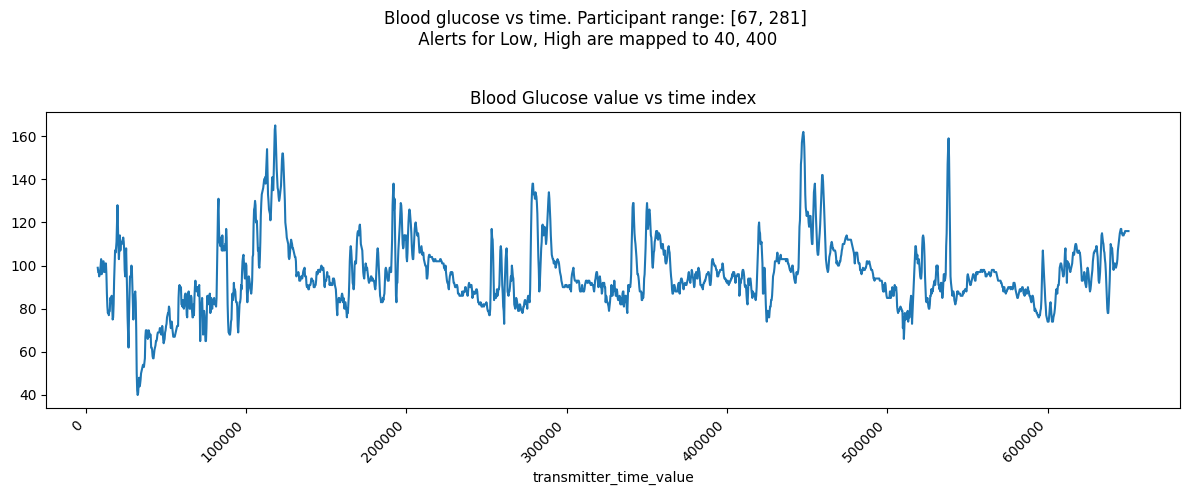

In [8]:
pid = 1057
data = df[df['participant_id'] == pid]

yaxis_adjusts_to_data = True
fig, ax = plt.subplots(figsize=(12, 5))
fig.suptitle(f'Blood glucose vs time. Participant range: [{bg_min}, {bg_max}]\n Alerts for Low, High are mapped to {low_value}, {high_value}\n')

data.plot.line(x='transmitter_time_value', y='blood_glucose_value', ax=ax, legend=False)
ax.set_title("Blood Glucose value vs time index")

plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


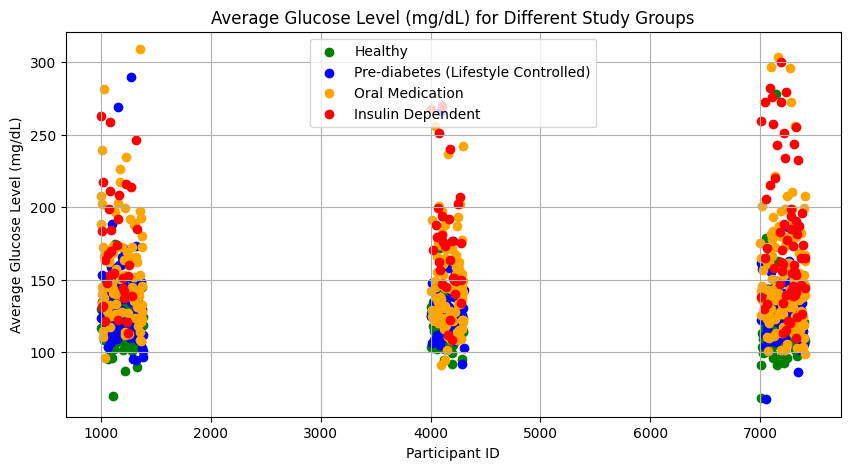

In [10]:
# Extract the study groups and participant IDs
healthy_participants = df_participants[df_participants['study_group'] == 'healthy']['participant_id'].tolist()
pre_diabetes_lifestyle_controlled_participants = df_participants[df_participants['study_group'] == 'pre_diabetes_lifestyle_controlled']['participant_id'].tolist()
oral_medication_participants = df_participants[df_participants['study_group'] == 'oral_medication_and_or_non_insulin_injectable_medication_controlled']['participant_id'].tolist()
insulin_dependent_participants = df_participants[df_participants['study_group'] == 'insulin_dependent']['participant_id'].tolist()

# Filter the dataframe for each group
healthy_df = dfm[dfm['participant_id'].isin(healthy_participants)]
pre_diabetes_lifestyle_controlled_df = dfm[dfm['participant_id'].isin(pre_diabetes_lifestyle_controlled_participants)]
oral_medication_df = dfm[dfm['participant_id'].isin(oral_medication_participants)]
insulin_dependent_df = dfm[dfm['participant_id'].isin(insulin_dependent_participants)]

# Plot the scatter plot
plt.figure(figsize=(10, 5))
plt.scatter(healthy_df['participant_id'], healthy_df['average_glucose_level_mg_dl'], color='green', label='Healthy')
plt.scatter(pre_diabetes_lifestyle_controlled_df['participant_id'], pre_diabetes_lifestyle_controlled_df['average_glucose_level_mg_dl'], color='blue', label='Pre-diabetes (Lifestyle Controlled)')
plt.scatter(oral_medication_df['participant_id'], oral_medication_df['average_glucose_level_mg_dl'], color='orange', label='Oral Medication')
plt.scatter(insulin_dependent_df['participant_id'], insulin_dependent_df['average_glucose_level_mg_dl'], color='red', label='Insulin Dependent')

plt.title('Average Glucose Level (mg/dL) for Different Study Groups')
plt.xlabel('Participant ID')
plt.ylabel('Average Glucose Level (mg/dL)')
plt.legend()
plt.grid(True)
plt.show()


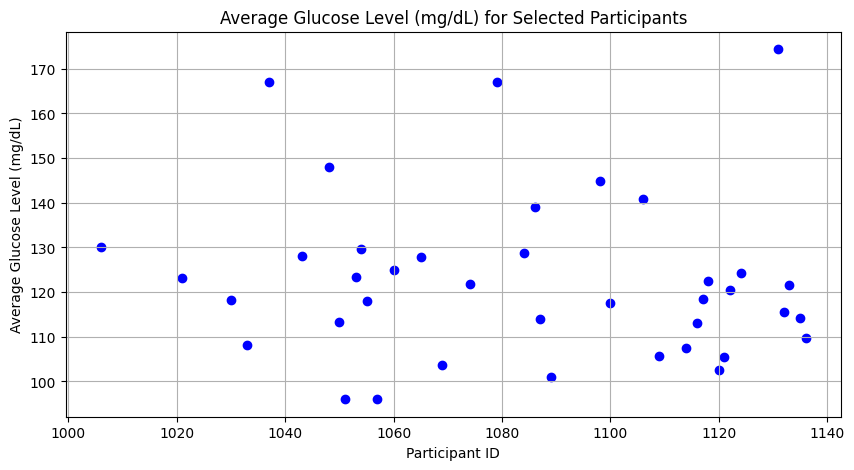

In [9]:
# List of participant IDs
participant_ids = [1006, 1021, 1030, 1033, 1037, 1043, 1048, 1050, 1051, 1053, 1054, 1055, 1057, 1060,
                   1065, 1069, 1074, 1079, 1084, 1086, 1087, 1089, 1098, 1100, 1106, 1109, 1114, 1116,
                   1117, 1118, 1120, 1121, 1122, 1124, 1131, 1132, 1133, 1135, 1136]

# Filter the dataframe for the specified participant IDs
filtered_df = dfm[dfm['participant_id'].isin(participant_ids)]

# Plot the scatter plot
plt.figure(figsize=(10, 5))
plt.scatter(filtered_df['participant_id'], filtered_df['average_glucose_level_mg_dl'], color='blue')
plt.title('Average Glucose Level (mg/dL) for Selected Participants')
plt.xlabel('Participant ID')
plt.ylabel('Average Glucose Level (mg/dL)')
plt.grid(True)
plt.show()

In [64]:
import os

# Create the directory if it doesn't exist
output_dir = os.path.join(pilot_data_root, "healthy_plots")
os.makedirs(output_dir, exist_ok=True)

# Get the list of healthy participant IDs
healthy_participants = df[df['study_group'] == 'healthy']['participant_id'].unique()

# Plot and save the graph for each healthy participant
for pid in healthy_participants:
    data = df[df['participant_id'] == pid]
    
    fig, ax = plt.subplots(figsize=(12, 5))
    fig.suptitle(f'Blood glucose vs time for Participant {pid}. Range: [{bg_min}, {bg_max}]\n Alerts for Low, High are mapped to {low_value}, {high_value}\n')
    
    data.plot.line(x='transmitter_time_value', y='blood_glucose_value', ax=ax, legend=False)
    ax.set_title("Blood Glucose value vs time index")
    
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    
    # Save the plot
    plot_path = os.path.join(output_dir, f'participant_{pid}.png')
    plt.savefig(plot_path)
    plt.close(fig)

print(f"Plots saved in {output_dir}")


Plots saved in C:/Users/nikhi/Box/AI-READI/working dataset/dataset/healthy_plots


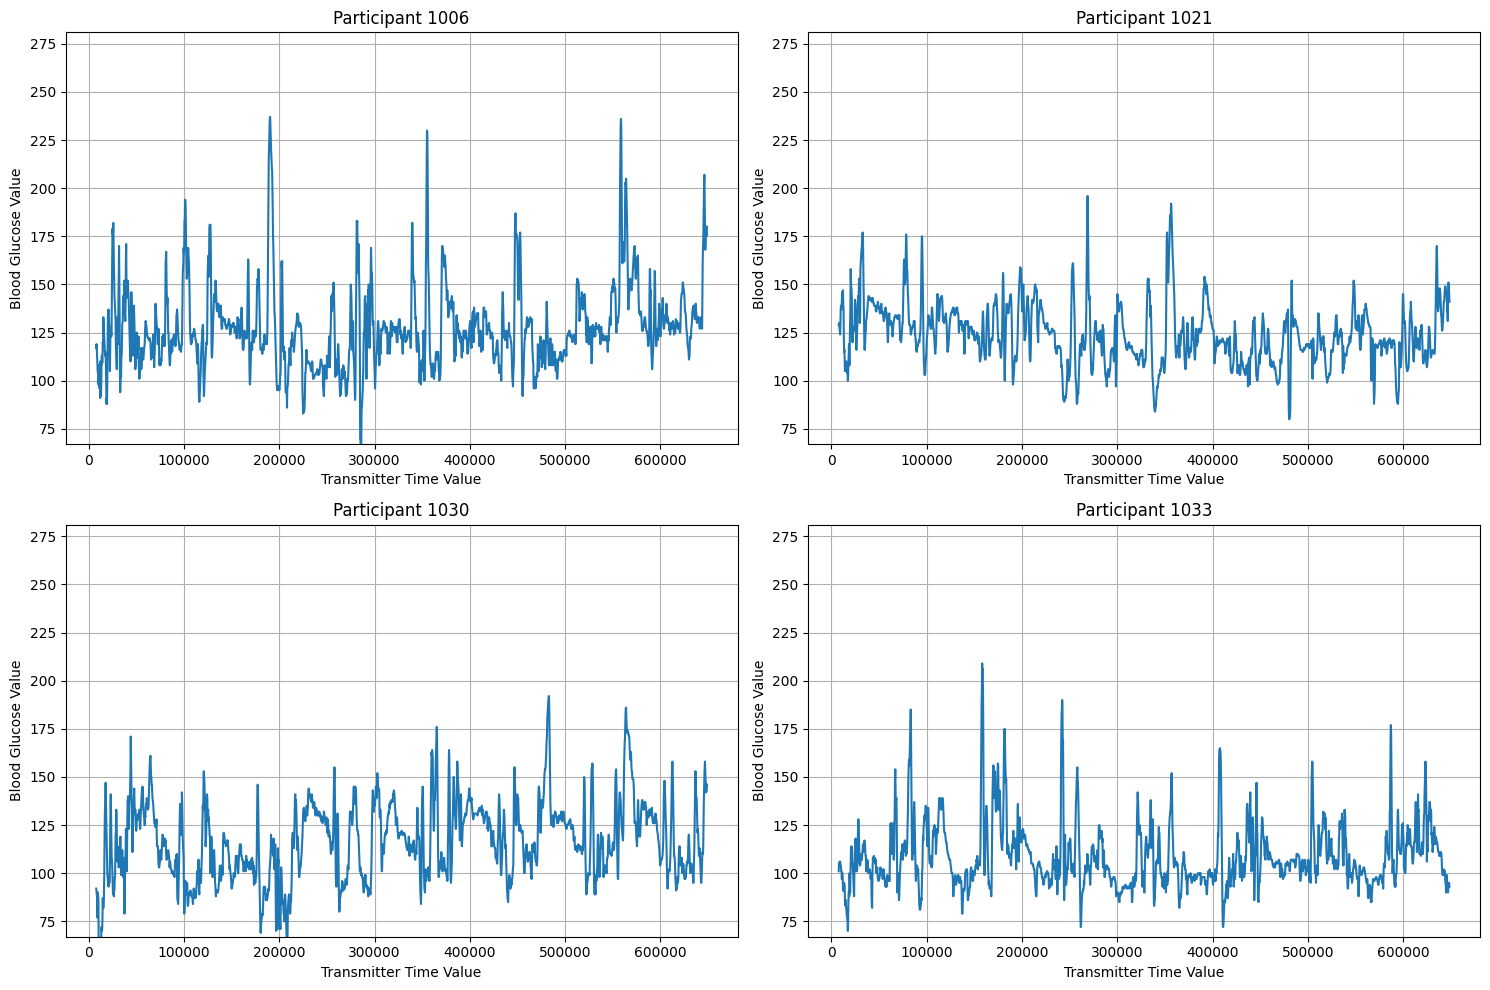

In [12]:
import matplotlib.pyplot as plt

nrows, ncols = 2, 2
fig, axs = plt.subplots(nrows, ncols, figsize=(15, 10))
axs = axs.flatten()

participant_ids = [1006, 1021, 1030, 1033]  

# Plot each participant's data in a separate subplot
for i, pid in enumerate(participant_ids):
    data = df[df['participant_id'] == pid]
    
    axs[i].plot(data['transmitter_time_value'], data['blood_glucose_value'])
    axs[i].set_title(f'Participant {pid}')
    axs[i].set_xlabel('Transmitter Time Value')
    axs[i].set_ylabel('Blood Glucose Value')
    axs[i].set_ylim([bg_min, bg_max])
    axs[i].grid(True)

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()

In [13]:
# Filter the data for the specific participant
pid = 1060
participant_data = df[df['participant_id'] == pid]

# Define the glucose ranges
low_range = (70, 140)
high_range = (140, float('inf'))

# Calculate the time spent in each range
time_in_low_range = 0
time_above_high_range = 0

for i in range(1, len(participant_data)):
    glucose_value = participant_data.iloc[i]['blood_glucose_value']
    time_diff = participant_data.iloc[i]['transmitter_time_value'] - participant_data.iloc[i - 1]['transmitter_time_value']
    
    if low_range[0] <= glucose_value <= low_range[1]:
        time_in_low_range += time_diff
    elif glucose_value > high_range[0]:
        time_above_high_range += time_diff

# Convert time from seconds to hours
time_in_low_range_hours = time_in_low_range / 3600
time_above_high_range_hours = time_above_high_range / 3600

print(f"Participant {pid} spent {time_in_low_range_hours:.2f} hours in the 70–140 mg/dL range.")
print(f"Participant {pid} spent {time_above_high_range_hours:.2f} hours above 140 mg/dL.")

Participant 1060 spent 150.33 hours in the 70–140 mg/dL range.
Participant 1060 spent 28.67 hours above 140 mg/dL.


In [58]:
# Filter the data for the specific participant
pid = 1079
participant_data = df[df['participant_id'] == pid]

# Define the glucose ranges
low_range = 70
high_range = 140

# Calculate Mean Blood Glucose (MBG)
mean_blood_glucose = participant_data['blood_glucose_value'].mean()

# Calculate Glucose Variability (Standard Deviation & Coefficient of Variation, CV%)
std_dev = participant_data['blood_glucose_value'].std()
cv_percent = (std_dev / mean_blood_glucose) * 100

# Calculate Time in Range (TIR), Time Above Range (TAR), and Time Below Range (TBR)
total_time = len(participant_data)
time_in_range = len(participant_data[(participant_data['blood_glucose_value'] >= low_range) & (participant_data['blood_glucose_value'] <= high_range)])
time_above_range = len(participant_data[participant_data['blood_glucose_value'] > high_range])
time_below_range = len(participant_data[participant_data['blood_glucose_value'] < low_range])

tir_percent = (time_in_range / total_time) * 100
tar_percent = (time_above_range / total_time) * 100
tbr_percent = (time_below_range / total_time) * 100

# Calculate the maximum contiguous time spent above the high range
max_contiguous_time_above_range = 0
current_streak = 0

for value in participant_data['blood_glucose_value']:
    if value > high_range:
        current_streak += 1
        if current_streak > max_contiguous_time_above_range:
            max_contiguous_time_above_range = current_streak
    else:
        current_streak = 0

# Print the results
print(f"Participant `{pid}` Glucose Analysis:")
print(f"Mean Blood Glucose (MBG): {mean_blood_glucose:.2f} mg/dL")
print(f"Glucose Variability (Standard Deviation): {std_dev:.2f} mg/dL")
print(f"Coefficient of Variation (CV%): {cv_percent:.2f}%")
print(f"Time in Range (TIR): {tir_percent:.2f}%")
print(f"Time Above Range (TAR): {tar_percent:.2f}%")
print(f"Time Below Range (TBR): {tbr_percent:.2f}%")
# Convert the maximum contiguous time above the high range into hours or minutes
max_contiguous_time_above_range_minutes = max_contiguous_time_above_range * 5
max_contiguous_time_above_range_hours = max_contiguous_time_above_range_minutes / 60

print(f"Max Contiguous Time Above Range: {max_contiguous_time_above_range_minutes} minutes ({max_contiguous_time_above_range_hours:.2f} hours)")


Participant `1079` Glucose Analysis:
Mean Blood Glucose (MBG): 166.83 mg/dL
Glucose Variability (Standard Deviation): 23.70 mg/dL
Coefficient of Variation (CV%): 14.21%
Time in Range (TIR): 13.99%
Time Above Range (TAR): 86.01%
Time Below Range (TBR): 0.00%
Max Contiguous Time Above Range: 1465 minutes (24.42 hours)


 Healthy Participants ID: [1006 1021 1030 1033 1037 1043 1048 1050 1051 1053 1054 1055 1057 1060
 1065 1069 1074 1079 1084 1086 1087 1089 1098 1100 1106 1109 1114 1116
 1117 1118 1120 1121 1122 1124 1131 1132 1133 1135 1136]
0.041 --> 0.034 --> 0.032 --> 0.032 --> 
Cluster labels: {np.int64(1006): np.int64(0), np.int64(1021): np.int64(0), np.int64(1030): np.int64(3), np.int64(1033): np.int64(3), np.int64(1037): np.int64(1), np.int64(1043): np.int64(0), np.int64(1048): np.int64(2), np.int64(1050): np.int64(3), np.int64(1051): np.int64(3), np.int64(1053): np.int64(0), np.int64(1054): np.int64(0), np.int64(1055): np.int64(0), np.int64(1057): np.int64(3), np.int64(1060): np.int64(0), np.int64(1065): np.int64(0), np.int64(1069): np.int64(3), np.int64(1074): np.int64(0), np.int64(1079): np.int64(1), np.int64(1084): np.int64(0), np.int64(1086): np.int64(2), np.int64(1087): np.int64(3), np.int64(1089): np.int64(3), np.int64(1098): np.int64(2), np.int64(1100): np.int64(3), np.int64(1106): np.in

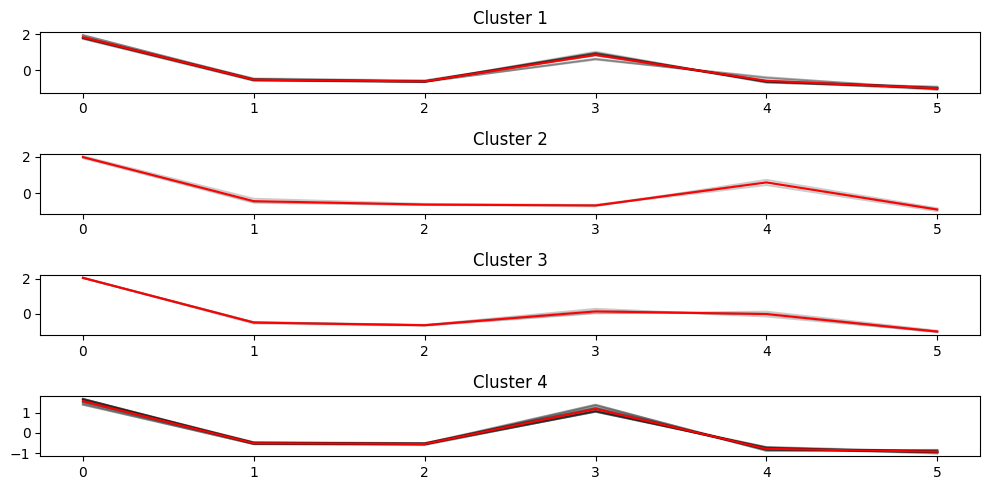

Participant `1006` Glucose Analysis:
Mean Blood Glucose (MBG): 127.46 mg/dL
Glucose Variability (Standard Deviation): 21.59 mg/dL
Coefficient of Variation (CV%): 16.94%
Time in Range (TIR): 81.52%
Time Above Range (TAR): 18.33%
Time Below Range (TBR): 0.14%


Participant `1021` Glucose Analysis:
Mean Blood Glucose (MBG): 124.04 mg/dL
Glucose Variability (Standard Deviation): 15.61 mg/dL
Coefficient of Variation (CV%): 12.58%
Time in Range (TIR): 87.23%
Time Above Range (TAR): 12.77%
Time Below Range (TBR): 0.00%


Participant `1030` Glucose Analysis:
Mean Blood Glucose (MBG): 116.99 mg/dL
Glucose Variability (Standard Deviation): 20.29 mg/dL
Coefficient of Variation (CV%): 17.34%
Time in Range (TIR): 88.87%
Time Above Range (TAR): 10.43%
Time Below Range (TBR): 0.70%


Participant `1033` Glucose Analysis:
Mean Blood Glucose (MBG): 108.56 mg/dL
Glucose Variability (Standard Deviation): 16.69 mg/dL
Coefficient of Variation (CV%): 15.37%
Time in Range (TIR): 95.28%
Time Above Range (TAR):

In [66]:
import numpy as np
import pandas as pd
from tslearn.clustering import TimeSeriesKMeans
from tslearn.preprocessing import TimeSeriesScalerMeanVariance
import matplotlib.pyplot as plt
import os

# Create the directory if it doesn't exist
output_dir = os.path.join(pilot_data_root, "healthy_plots")
os.makedirs(output_dir, exist_ok=True)

# Get the list of healthy participant IDs
healthy_participants = df[df['study_group'] == 'healthy']['participant_id'].unique()
print(f" Healthy Participants ID: {healthy_participants}")

# Initialize lists to store features for clustering
features = []

# Calculate metrics and prepare data for clustering
for pid in healthy_participants:
    data = df[df['participant_id'] == pid]
    blood_glucose_values = data['blood_glucose_value'].values
    
    mean_blood_glucose = np.mean(blood_glucose_values)
    std_dev = np.std(blood_glucose_values)
    cv_percent = (std_dev / mean_blood_glucose) * 100
    
    # Define thresholds for TIR, TAR, TBR
    low_threshold = 70
    high_threshold = 140
    
    tir_percent = np.sum((blood_glucose_values >= low_threshold) & (blood_glucose_values <= high_threshold)) / len(blood_glucose_values) * 100
    tar_percent = np.sum(blood_glucose_values > high_threshold) / len(blood_glucose_values) * 100
    tbr_percent = np.sum(blood_glucose_values < low_threshold) / len(blood_glucose_values) * 100
    
    # Append features for clustering
    features.append([mean_blood_glucose, std_dev, cv_percent, tir_percent, tar_percent, tbr_percent])

# Convert features to numpy array and normalize
features = np.array(features)
scaler = TimeSeriesScalerMeanVariance()
features_scaled = scaler.fit_transform(features)

# Define the number of clusters
n_clusters = 4  # Adjust the number of clusters as needed

# Perform K-Means clustering
model = TimeSeriesKMeans(n_clusters=n_clusters, metric="euclidean", verbose=True, random_state=42)
labels = model.fit_predict(features_scaled)

# Print the cluster labels
cluster_labels = {healthy_participants[i]: labels[i] for i in range(len(labels))}
print(f"Cluster labels: {cluster_labels}")

# Plot the clustered participants
plt.figure(figsize=(10, 5))
for yi in range(n_clusters):
    plt.subplot(n_clusters, 1, yi + 1)
    for xx in features_scaled[labels == yi]:
        plt.plot(xx, "k-", alpha=0.2)
    plt.plot(model.cluster_centers_[yi], "r-")
    plt.title(f"Cluster {yi + 1}")
plt.tight_layout()
plt.show()

# Print the results for each participant
for i, pid in enumerate(healthy_participants):
    print(f"Participant `{pid}` Glucose Analysis:")
    print(f"Mean Blood Glucose (MBG): {features[i][0]:.2f} mg/dL")
    print(f"Glucose Variability (Standard Deviation): {features[i][1]:.2f} mg/dL")
    print(f"Coefficient of Variation (CV%): {features[i][2]:.2f}%")
    print(f"Time in Range (TIR): {features[i][3]:.2f}%")
    print(f"Time Above Range (TAR): {features[i][4]:.2f}%")
    print(f"Time Below Range (TBR): {features[i][5]:.2f}%")
    print("\n")